In [1]:
# Descomente e rode para usar no colab
! pip install git+https://github.com/flaviovdf/musica.git

  Cloning https://github.com/flaviovdf/musica.git to /tmp/pip-req-build-0nvzc9td
  Running command git clone -q https://github.com/flaviovdf/musica.git /tmp/pip-req-build-0nvzc9td
     |████████████████████████████████| 207 kB 8.5 MB/s 
     |████████████████████████████████| 126 kB 63.8 MB/s 
     |████████████████████████████████| 65 kB 4.0 MB/s 
  Created wheel for musica-dcc-ufmg: filename=musica_dcc_ufmg-0.1-py3-none-any.whl size=3414 sha256=c00ed743f2b239e90f306a347ed7bcf6ee4d7a43bfb042142e10fcca1181a71f
  Stored in directory: /tmp/pip-ephem-wheel-cache-o9chrtbo/wheels/94/cb/e0/72e4ee72153bf78a970722ac92a93e8a8f31c1853e32a3d1bc
Successfully built musica-dcc-ufmg


# Shazam do GTZAN

**Objetivos**
1. Entender o Shazam!

**Resultado Esperado**
1. Saber criar um índice de constelações
1. Realizar consultas no mesmo

**Caso queira indexar tudo, recomendo o uso da biblioteca sparse, descomente abaixo**

In [2]:
from μsica import μsf
from μsica import μsp

from numba import jit

import librosa
import librosa.display

import IPython.display as ipd

import matplotlib.pyplot as plt

import numpy as np
import os
import pandas as pd

In [3]:
μsp.init_matplotlib()
plt.ion()

In [4]:
μsf.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/archive.zip',
             'archive.zip', False)
μsf.download('https://homepages.dcc.ufmg.br/~flaviovdf/mir/lab09/queryPublic_George.zip',
             'queryPublic_George.zip', False)

archive.zip: 1.21GB [01:26, 15.1MB/s]
queryPublic_George.zip: 723MB [00:49, 15.3MB/s]


In [6]:
μsf.extract('archive.zip', '.')

In [7]:
μsf.extract('queryPublic_George.zip', '.')

In [8]:
! ls

 archive.zip  'mir-2013-GeorgeDataset_snippet(10sec)_1062'   sample_data
 Data	       queryPublic_George.zip


## Introdução

Neste notebook vamos tentar montar um [Shazam](https://shazam.com). Criado em meados de 2003 \[[1](https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf)\], o Shazam é um serviço que identifica músicas com base em clipes pequenos. No começo dos anos 2010s, o advento de aplicativos de celulares popularizou o serviço Shazam. Com o passar dos anos, as ideias do Shazam foram copiadas por empresas como a Google a Apple, que incluem variações do serviço de descoberta nos seus sistemas operacionais Android e IOs. Se não me engano, a Apple usa APIs do Shazam, enquanto a Google tem sua versões própria.

![](https://digitalagencynetwork.com/wp-content/uploads/2017/12/confirmed-apple-bought-shazam-app-reasonable-point.jpg)

O funcionamento do Shazam é feito através da técnica de *audio fingerprinting*. Aqui, um índice invertido de atributos musicais é criado. Com tal índice, podemos rapidamente identificar uma música através de um clipe pequeno da mesma. A figura abaixo mostra a ideia de como um serviço seria implementado no mundo real. Aqui, vamos fazer uma versão simples em memória.

![Audio Finger](https://www.audiolabs-erlangen.de/resources/MIR/FMP/data/C7/FMP_C7_F02.png)

## Base de Dados

Para nossa tarefa, vamos fazer uso da base GTZAN. A base GTZAN é composta por 1.000 trechos de música e áudio de meio minuto, classificados individualmente em dez categorias. Por hora, vamos ignorar as categorias e focar apenas nas músicas. Para um melhor entendimento do GTZAN leia a referência \[[2](https://arxiv.org/pdf/1306.1461.pdf)\]. 

### A base de dados que será indexada (GTZAN)

Toda a base GTZAN pode ser encontrada no [Kaggle](https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification). Caso necessite, uma versão também pode ser encontrada no drive junto deste notebook.

Abaixo mostramos as pastas e arquivos do GTZAN. Tais músicas vem no formato wav. Sua tarefa será montar um índice de um **subconjunto** de tais músicas. Já explico.

In [19]:
! ls Data/genres_original

blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [20]:
! ls Data/genres_original/blues | head

blues.00000.wav
blues.00001.wav
blues.00002.wav
blues.00003.wav
blues.00004.wav
blues.00005.wav
blues.00006.wav
blues.00007.wav
blues.00008.wav
blues.00009.wav


### A base de dados de consulta (MIREX-2020)

Como sua tarefa é montar um Shazam, precisamos de uma base de consultas. Desde 2005, a [Music Information Retrieval Evaluation eXchange (MIREX 2020)](https://www.music-ir.org/mirex) organia competições no tema de recuperação de informação musical. Já fazem alguns anos, desde 2013, onde anualmente uma das competições do MIREX é no tema de *audio fingerprinting* (nossa tarefa). O link ao lado contém a descrição da tarefa [Audio Fingerprinting MIREX 2020](https://www.music-ir.org/mirex/wiki/2020:Audio_Fingerprinting).

Para simular o uso do Shazam, junto com tal competição, uma base de dados de consultas é fornecida. Tal base foi gravada em telefones celulares em diferentes ambientes. Para entender o formato de tal base, segue uma lista dos arquivos.

In [11]:
! ls -l mir-2013-GeorgeDataset_snippet\(10sec\)_1062

total 921788
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00000-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00000-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00000-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00003-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00003-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00003-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00004-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00004-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00005-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00005-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00005-snippet-10-20.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00009-snippet-10-0.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 blues.00009-snippet-10-10.wav
-rw-r--r-- 1 root root 884782 Jan 13 19:56 

Observe como cada arquivo corresponde a uma música do GTZAN. Além do mais, três clipes de 10 segundos são fornecidos por música. Por exemplos, a música `blues.00000.wav`do GTZAN tem como respostas os clipes: `blues.00000-snippet-10-0.wav`, `blues.00000-snippet-10-10.wav`, `blues.00000-snippet-10-20.wav`.

## Sua Tarefa

Sabendo das bases acima, sua tarefa será em indexar e mensurar a Precision@10 (fração de acertos na primeira posição retornada) das músicas acima. **Por questões de memória limitada, você pode indexar apenas as músicas de consulta, não precisa indexar todo GTZAN. Faça tudo na memória principal mesmo**.

Para realizar sua tarefa crie mapas de constetalação das músicas e da consulta.

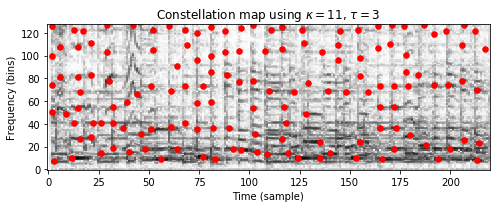

### *Importante*: Fourier no GTZAN

No GTZAN, cada música é gravada a uma taxa de amostragem de 22,05 kHz e arquivos de áudio mono de 16 bits no formato `.wav`. *Como toda música tem a mesma taxa de amostragem, os índices discretos da transformada de Fourier são os mesmos para todas as músicas. ELAS JÁ VEM BINARIZADAS NO EIXO-Y do mapa de constelação*.

## Carregando os Espectrogramas

O código abaixo carrega os espectrogramas. Coloquei também um função que plota os mesmos.

In [37]:
import warnings
warnings.filterwarnings('ignore')

def plot_spec(stft, sr, constelation=None):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max),
                                   y_axis='log',
                                   x_axis='time',
                                   hop_length=sr,
                                   ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    if constelation is not None and constelation.any():
        x, y = np.where(constelation.T)
        ax.scatter(x, y, s=100, alpha=0.6, edgecolor='k')
    fig.show()

**Observe como passo o `hop_length=sr` no stft**. Como estou com uma música com taxa SR por segundo, tiro a média a cada SR frames. Isso deixa meu espectrograma em SEGUNDOS. Algumas musicas passam um pouco de 30 segundos, portanto pego os trinta na marra.

In [38]:
def my_stft(wave, sr):
    stft_complex = librosa.stft(wave, hop_length=sr) # deve ter approx 30 secs
    stft = np.abs(stft_complex) # tira a norma do real e imag
    return stft[:, :30] # força 30 secs

(1025, 30)

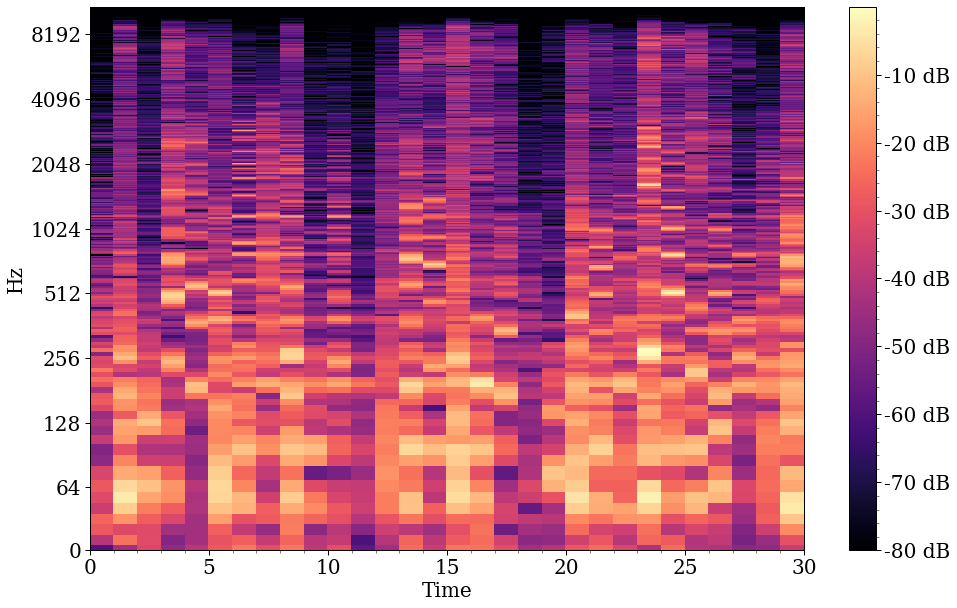

In [39]:
wave, sr = librosa.load('Data/genres_original/blues/blues.00001.wav',
                        mono=True)
stft = my_stft(wave, sr)
plot_spec(stft, sr)
stft.shape

### Mapa de Constelação

O mapa pode ser implementado com a chamada: https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.maximum_filter.html. O `mode='constant'` faz um preenchimento nas bordas para garantir que tudo funcione. O `size` diz o tamanho do filtro que vamos usar.

In [40]:
from scipy import ndimage

def constellation_map(stft, kappa=7, tau=7, thresh=0.01):
    result = ndimage.maximum_filter(stft, size=[2*kappa+1, 2*tau+1],
                                    mode='constant')
    C = np.logical_and(stft == result, result > thresh)
    return C

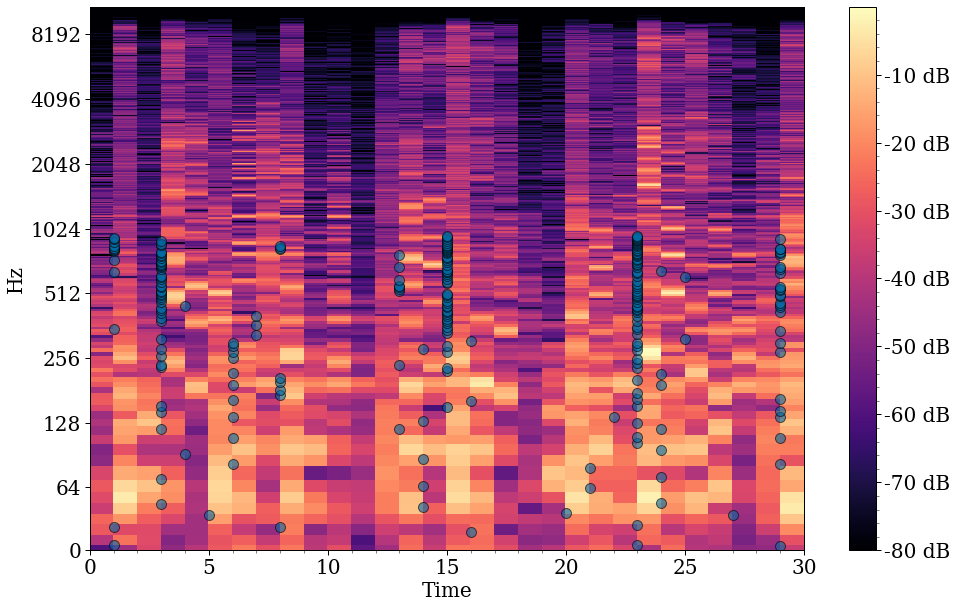

In [41]:
constelation = constellation_map(stft, kappa=5, tau=5)
plot_spec(stft, sr, constelation)

## Índice

Observe como cada consulta precisa ser comparada com todas as seções (tendo a mesma duração da consulta) de todas as músicas contidas no base de dados. Tal estratégia de busca exaustiva, cujo tempo de execução depende linearmente do número e do tamanho da base de dados, não é viável. Portanto você deve implementar um índice como visto em sala de aula. A função `match_query_gtzan` lhe ajuda a carregar apenas os arquivos que existem na base de consultas.

In [42]:
import glob
import os

def match_query_gtzan():
    rv = {}
    path = os.path.join('mir-2013-GeorgeDataset_snippet(10sec)_1062', '*.wav')
    for wav_fpath in glob.glob(path):
        file_name = os.path.basename(wav_fpath)
        file_name_gztan = '{}{}'.format(file_name.split('-')[0], '.wav')
        genre = file_name_gztan.split('.')[0]
        rv[wav_fpath] = os.path.join('Data', 'genres_original', genre,
                                     file_name_gztan)
    return rv
matches = match_query_gtzan()
print(list(matches.items())[:10])

[('mir-2013-GeorgeDataset_snippet(10sec)_1062/rock.00013-snippet-10-20.wav', 'Data/genres_original/rock/rock.00013.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/disco.00019-snippet-10-20.wav', 'Data/genres_original/disco/disco.00019.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/hiphop.00045-snippet-10-10.wav', 'Data/genres_original/hiphop/hiphop.00045.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/hiphop.00049-snippet-10-20.wav', 'Data/genres_original/hiphop/hiphop.00049.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/country.00079-snippet-10-0.wav', 'Data/genres_original/country/country.00079.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/jazz.00050-snippet-10-0.wav', 'Data/genres_original/jazz/jazz.00050.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/hiphop.00040-snippet-10-20.wav', 'Data/genres_original/hiphop/hiphop.00040.wav'), ('mir-2013-GeorgeDataset_snippet(10sec)_1062/reggae.00003-snippet-10-0.wav', 'Data/genres_original/reggae/reggae.00003.wav')

In [43]:
from collections import defaultdict

def index(colecao_de_stfts, kappa, tau):
    pass
        
index(matches.values(), kappa=5, tau=5)

In [54]:
index = defaultdict(lambda: defaultdict(list))
for row, col in zip(*np.where(constelation)):
    index[row][col].append('d')

## Problemas

1. Implemente o índice acima. É possível implementar o mesmo na memória. Use estruturas python ou uma matriz esparsa 3d (um tensor). Veja a descrição do lab. Da para fazer sem o sparse, mas não deve funcionar na base toda.
1. Realize as consultas e mensure o seu valor de precision@10
1. Qual o efeito do kappa e do tau no seu resultado?
1. Mude seu código para funciona na base toda (*extra*)